## Sentiment Analysis with Tweepy

### Set up environment

In [ ]:
!pip install tweepy==4.9.0

In [ ]:
!pip install textblob

In [ ]:
!pip install wordcloud

In [2]:
import tweepy
import pandas as pd
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')

import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Aniket\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Twitter Authentication

In [3]:
client = tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAAOVMjwEAAAAAz3YAf8h62laWvirfBC9hKbH%2B5fs%3DZQkG4Pc7qN0uE157pmsoYWMb7b8JgacVEAqYEAFnpvK86uK5dF')

### Get recent public tweets on a keyword

In [4]:
# Pull tweets from twitter

query = '#apple -is:retweet lang:en'
paginator = tweepy.Paginator(
    client.search_recent_tweets,           
    query=query,                           
    max_results=100,                       
    limit=10                               
)
tweet_list = []

#flatten() - return a copy of the array collapsed into one dimensional.
for tweet in paginator.flatten(): 
    tweet_list.append(tweet)
    print(tweet)

Somehow I see this being true - Tim Cook Says He's Ready To Pull Twitter From App Store Once President Xi Gives The Order https://t.co/VknIoSczyR via @TheBabylonBee #Apple @tim_cook @elonmusk #Twitter #AppleVsTwitter #ChinaControlsApple
The #apple Watch Action Button’s sole purpose is to do your bidding https://t.co/QS2lpwyxNg
4) Instead of #Global pasteboard #developers can create private UIPasteboards which can only be accessed by certain selected applications.

#Apple #ios #Data #security #DataSecurity #infosecurity #infosec #bugbounty #community #cyber #CyberSec
November saw the release of patches from the likes of #Apple’s #iOS, #Google #Chrome, 3Firefox, &amp; #Microsoft #Windows to fix multiple #security #vulnerabilities. Some of these issues are pretty severe, &amp; several have already been exploited by attackers. https://t.co/MqxFmQkJxm
If you use #Apple products you are a fool. Apple is in bed with communist tyrants-Xi and Joe Biden. They are watching everything you say &amp

In [5]:
#Creating new dataframe and new features
tweet_list_df = pd.DataFrame(tweet_list)
tweet_list_df = pd.DataFrame(tweet_list_df['text'])
tweet_list_df.head(5)

,text
0,Somehow I see this being true - Tim Cook Says ...
1,The #apple Watch Action Button’s sole purpose ...
2,4) Instead of #Global pasteboard #developers c...
3,November saw the release of patches from the l...
4,If you use #Apple products you are a fool. App...


In [6]:
tweet_list_df.tail()

,text
995,Chef's Dish on Why Apple is Good Fall or Holid...
996,App Store Awards celebrate the \n👏best apps an...
997,Elon Musk has accused Apple Inc of threatening...
998,@juanchepeguezo @elonmusk @tim_cook @nayibbuke...
999,"GG @Seihuko_, on SoSkills app 🚀\n\nDownload li..."


In [7]:
tweet_list_df.shape

(1000, 1)

In [8]:
tweet_list_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


In [9]:
tweet_list_df.dtypes

text    object
dtype: object

In [10]:
np.sum(tweet_list_df.isnull().any(axis=1))

0

### Data preprocessing

In [11]:
def preprocess_tweet(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove RT
    sentence = re.sub('RT @\w+: '," ", sentence)

    # Remove special characters
    sentence = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    return sentence

In [12]:
cleaned_tweets = []

for tweet in tweet_list_df['text']:
  cleaned_tweet = preprocess_tweet(tweet)
  cleaned_tweets.append(cleaned_tweet)

In [13]:
tweet_list_df['cleaned'] = pd.DataFrame(cleaned_tweets)
tweet_list_df.head(5)

,text,cleaned
0,Somehow I see this being true - Tim Cook Says ...,somehow see this being true tim cook says he r...
1,The #apple Watch Action Button’s sole purpose ...,the apple watch action button sole purpose is ...
2,4) Instead of #Global pasteboard #developers c...,4 instead of global pasteboard developers can ...
3,November saw the release of patches from the l...,november saw the release of patches from the l...
4,If you use #Apple products you are a fool. App...,if you use apple products you are fool apple i...


In [14]:
tweet_list_df.tail(6)

,text,cleaned
994,"#ElonMusk has declared war on Apple, and the #...",elonmusk has declared war on apple and the te...
995,Chef's Dish on Why Apple is Good Fall or Holid...,chef dish on why apple is good fall or holiday...
996,App Store Awards celebrate the \n👏best apps an...,app store awards celebrate the best apps and g...
997,Elon Musk has accused Apple Inc of threatening...,elon musk has accused apple inc of threatening...
998,@juanchepeguezo @elonmusk @tim_cook @nayibbuke...,cook apple could die very soon
999,"GG @Seihuko_, on SoSkills app 🚀\n\nDownload li...",gg on soskills app download links apple androi...


#### Removing Stopwords

In [15]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [16]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
tweet_list_df['cleaned'] = tweet_list_df['cleaned'].apply(lambda text: cleaning_stopwords(text))
tweet_list_df['cleaned'].head()

0    somehow see true tim cook says ready pull twit...
1       apple watch action button sole purpose bidding
2    4 instead global pasteboard developers create ...
3    november saw release patches likes apple ios g...
4    use apple products fool apple bed communist ty...
Name: cleaned, dtype: object

#### Applying Stemming

In [17]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
tweet_list_df['cleaned']= tweet_list_df['cleaned'].apply(lambda x: stemming_on_text(x))
tweet_list_df['cleaned'].head()

0    somehow see true tim cook says ready pull twit...
1       apple watch action button sole purpose bidding
2    4 instead global pasteboard developers create ...
3    november saw release patches likes apple ios g...
4    use apple products fool apple bed communist ty...
Name: cleaned, dtype: object

### Generate Sentiment Labels

In [18]:
#Calculating Negative, Positive, Neutral and Compound values

tweet_list_df[['polarity', 'subjectivity']] = tweet_list_df['cleaned'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tweet_list_df['cleaned'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    
    if comp <= -0.05:
        tweet_list_df.loc[index, 'sentiment'] = "negative"
    elif comp >= 0.05:
        tweet_list_df.loc[index, 'sentiment'] = "positive"
    else:
        tweet_list_df.loc[index, 'sentiment'] = "neutral"
    tweet_list_df.loc[index, 'neg'] = neg
    tweet_list_df.loc[index, 'neu'] = neu
    tweet_list_df.loc[index, 'pos'] = pos
    tweet_list_df.loc[index, 'compound'] = comp

print(tweet_list_df.head(5))
tweet_list_df.tail()

                                                text  \
0  Somehow I see this being true - Tim Cook Says ...   
1  The #apple Watch Action Button’s sole purpose ...   
2  4) Instead of #Global pasteboard #developers c...   
3  November saw the release of patches from the l...   
4  If you use #Apple products you are a fool. App...   

                                             cleaned  polarity  subjectivity  \
0  somehow see true tim cook says ready pull twit...  0.275000      0.575000   
1     apple watch action button sole purpose bidding  0.050000      0.175000   
2  4 instead global pasteboard developers create ...  0.071429      0.315476   
3  november saw release patches likes apple ios g...  0.083333      0.333333   
4  use apple products fool apple bed communist ty...  0.016667      0.033333   

  sentiment    neg    neu    pos  compound  
0  positive  0.000  0.782  0.218    0.6486  
1   neutral  0.000  1.000  0.000    0.0000  
2  positive  0.000  0.742  0.258    0.6808  
3 

,text,cleaned,polarity,subjectivity,sentiment,neg,neu,pos,compound
995,Chef's Dish on Why Apple is Good Fall or Holid...,chef dish apple good fall holiday ingredient p...,0.700000,0.600000,positive,0.000,0.781,0.219,0.6808
996,App Store Awards celebrate the \n👏best apps an...,app store awards celebrate best apps games 202...,0.500000,0.350000,positive,0.000,0.451,0.549,0.9766
997,Elon Musk has accused Apple Inc of threatening...,elon musk accused apple inc threatening block ...,0.033333,0.066667,negative,0.286,0.714,0.000,-0.8555
998,@juanchepeguezo @elonmusk @tim_cook @nayibbuke...,cook apple could die soon,0.000000,0.000000,negative,0.494,0.506,0.000,-0.5994
999,"GG @Seihuko_, on SoSkills app 🚀\n\nDownload li...",gg soskills app download links apple android j...,0.000000,0.000000,positive,0.000,0.833,0.167,0.5267


### Sentiment Visualisation

In [19]:
#Creating new data frames for all sentiments (positive, negative and neutral)

tweet_list_df_negative = tweet_list_df[tweet_list_df["sentiment"]=="negative"]
tweet_list_df_positive = tweet_list_df[tweet_list_df["sentiment"]=="positive"]
tweet_list_df_neutral = tweet_list_df[tweet_list_df["sentiment"]=="neutral"]

#### Donut Charts

In [20]:
#Function for count_values_in single columns

def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [17]:
#Count_values for sentiment
count_values_in_column(tweet_list_df,"sentiment")

,Total,Percentage
positive,495,49.5
neutral,285,28.5
negative,220,22.0


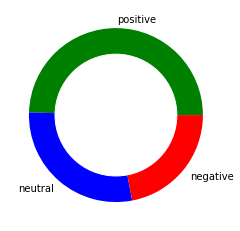

In [18]:
# create data for Pie Chart
pichart = count_values_in_column(tweet_list_df,"sentiment")

names= pichart.index
size=pichart["Percentage"]

my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

#### Distribution of data

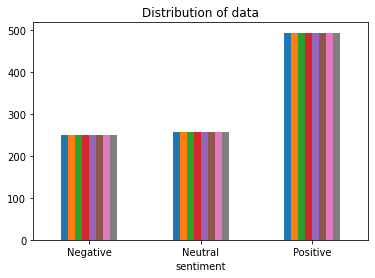

In [21]:
ax = tweet_list_df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Neutral','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(tweet_list_df['text']), list(tweet_list_df['sentiment'])

<AxesSubplot:xlabel='sentiment', ylabel='count'>

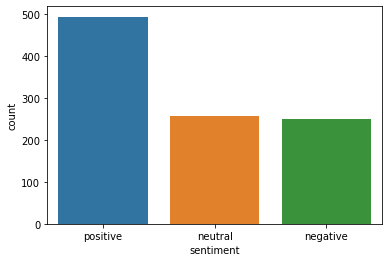

In [22]:
import seaborn as sns
sns.countplot(x='sentiment', data=tweet_list_df)

#### Word Clouds

In [23]:
#Function to Create Wordcloud

def create_wordcloud(text):
    mask = np.array(Image.open("cloud.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
                  mask = mask,
                  max_words=100,
                  stopwords=stopwords,
                  repeat=True)
    wc.generate(str(text))
    wc.to_file("c1_wordcloud.png")
    print("Word Cloud Saved Successfully")
    path="c1_wordcloud.png"
    display(Image.open(path))

Word Cloud Saved Successfully


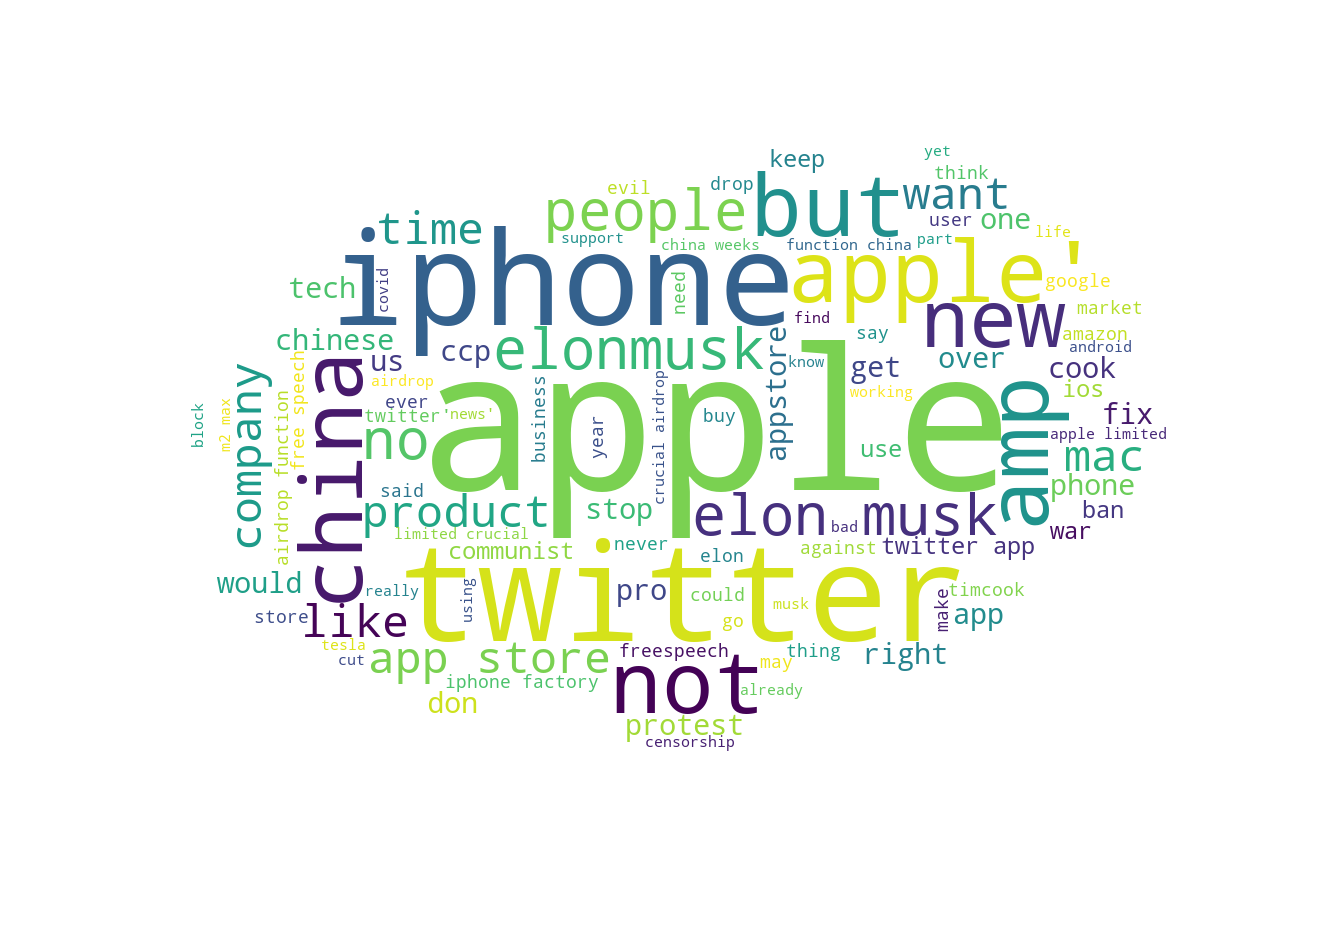

In [24]:
# Creating wordcloud for all tweets

create_wordcloud(tweet_list_df_negative["cleaned"].values)

Word Cloud Saved Successfully


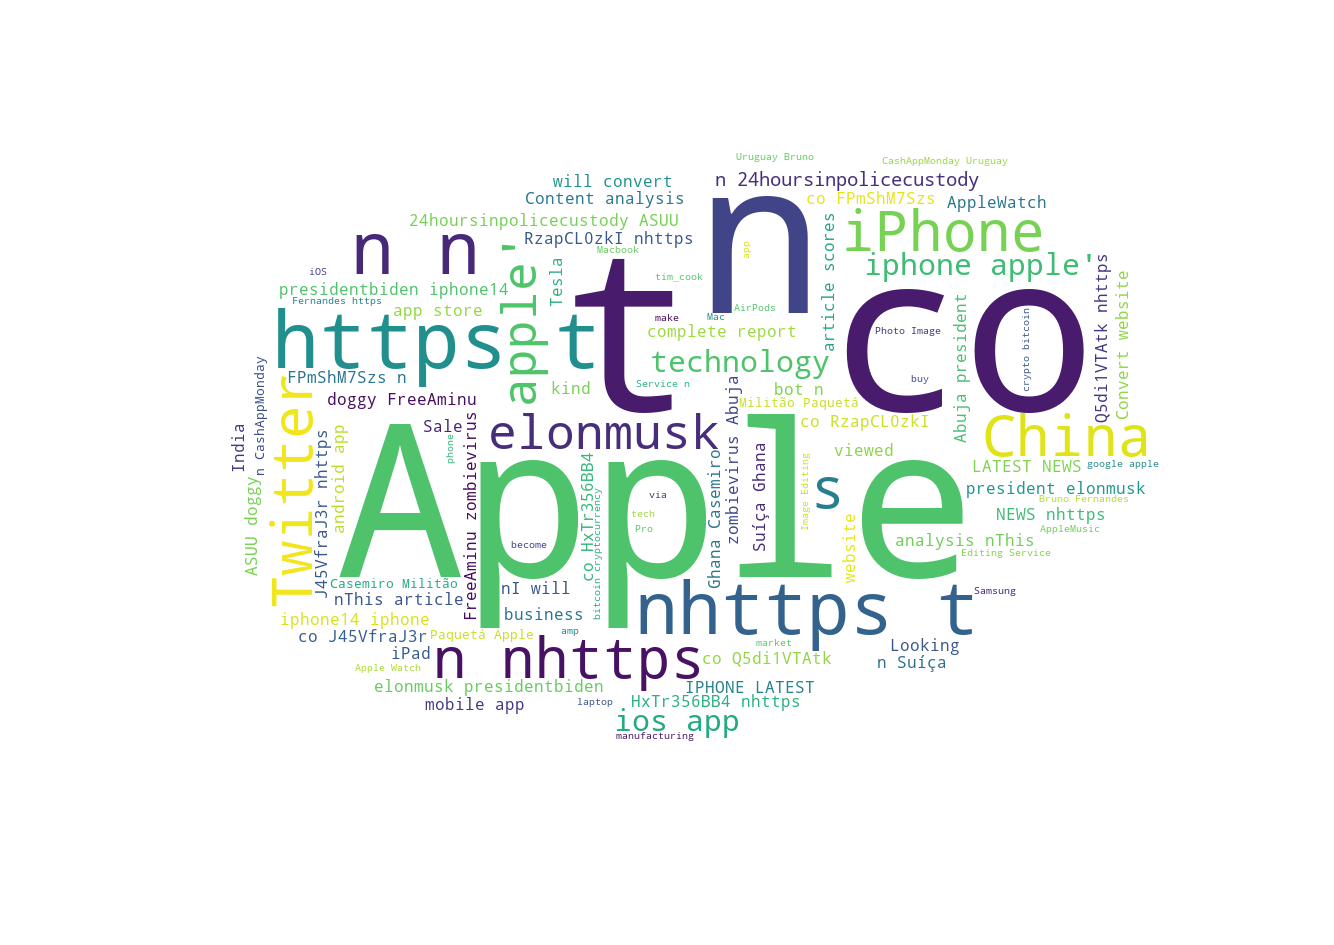

In [34]:
create_wordcloud(tweet_list_df_neutral["text"].values)

Word Cloud Saved Successfully


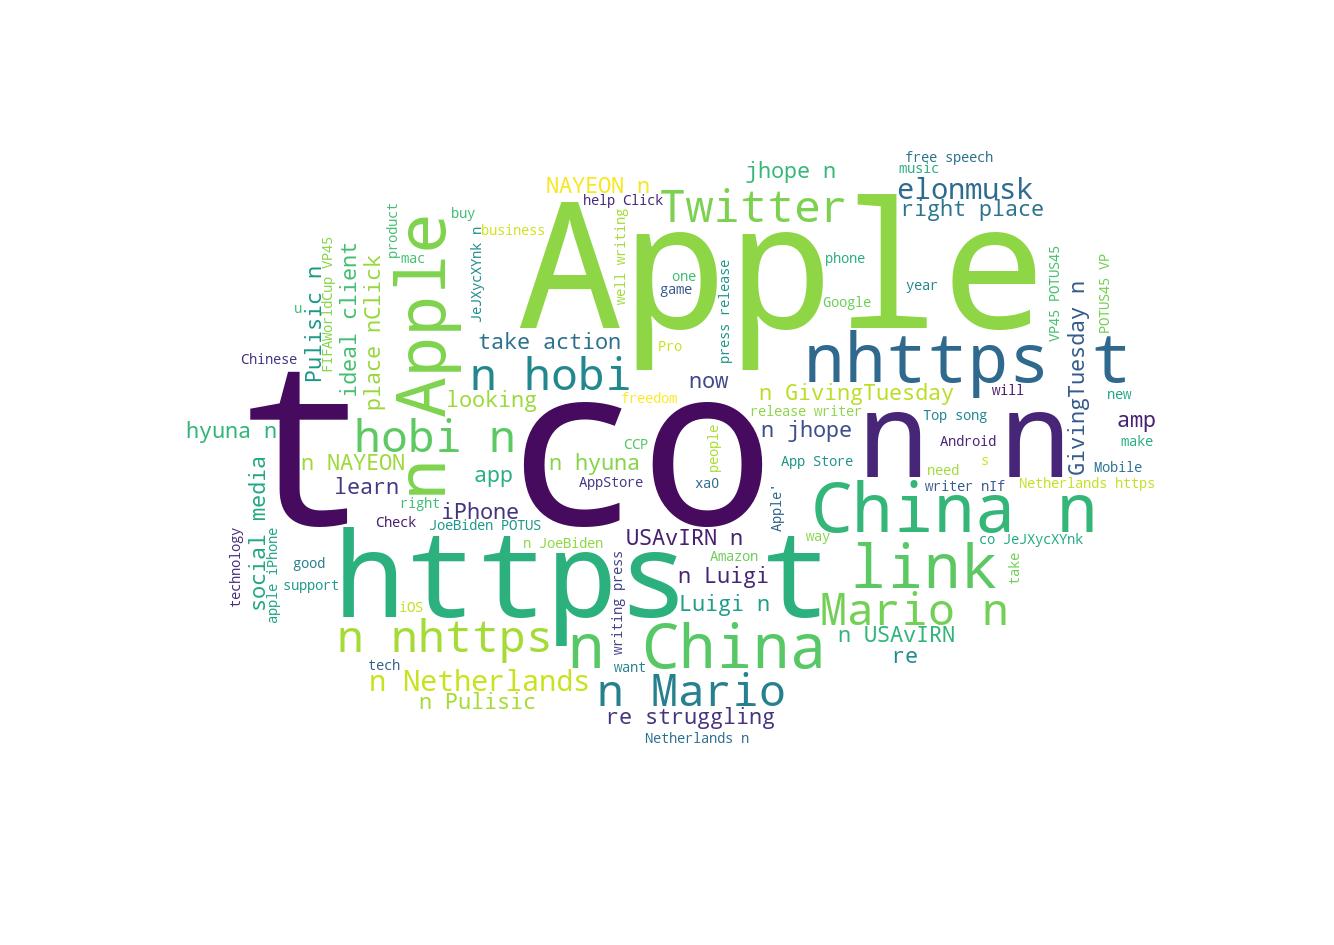

In [33]:
create_wordcloud(tweet_list_df_positive["text"].values)

Word Cloud Saved Successfully


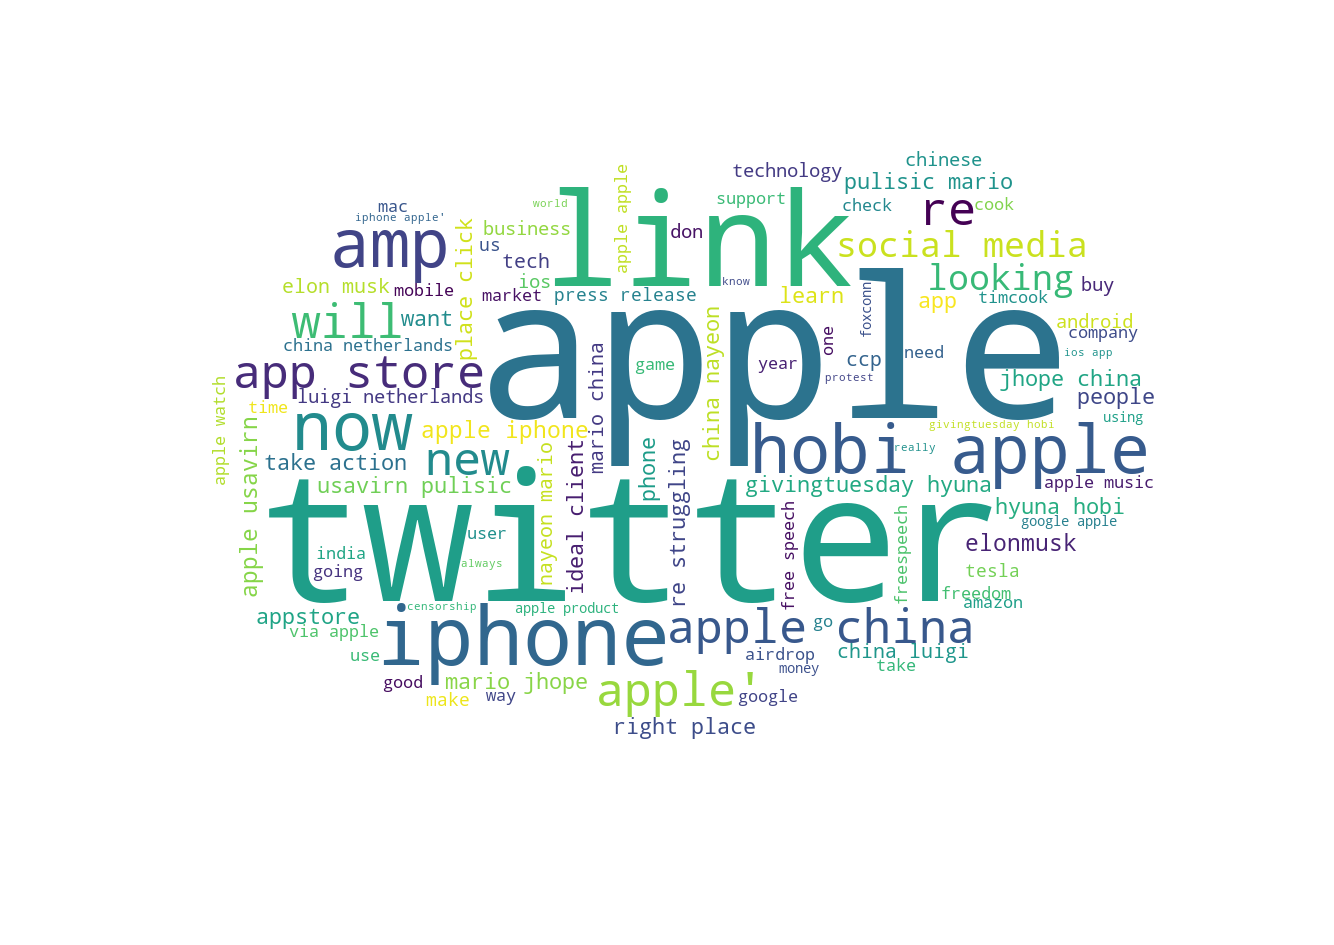

In [32]:
create_wordcloud(tweet_list_df["cleaned"].values)

#### Model

In [21]:
X=tweet_list_df.cleaned
y=tweet_list_df.sentiment

In [22]:
# Separating the 95% data for training data and 5% for testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  15896


C:\Users\muska\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [25]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

#### Model evaluation

In [42]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = True, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

C:\Users\muska\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\muska\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\muska\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        15
     neutral       0.75      0.23      0.35        13
    positive       0.46      0.95      0.62        22

    accuracy                           0.48        50
   macro avg       0.40      0.40      0.32        50
weighted avg       0.40      0.48      0.36        50



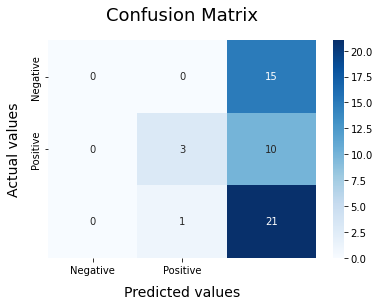

In [43]:
from sklearn.naive_bayes import BernoulliNB
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)


#### Text Insights

In [21]:
#Calculating tweet's lenght and word count
tweet_list_df['text_len'] = tweet_list_df['cleaned'].astype(str).apply(len)
tweet_list_df['text_word_count'] = tweet_list_df['cleaned'].apply(lambda x: len(str(x).split()))

In [22]:
round(pd.DataFrame(tweet_list_df.groupby("sentiment").text_len.mean()),2)

,text_len
sentiment,
negative,148.63
neutral,120.45
positive,176.64


In [23]:
round(pd.DataFrame(tweet_list_df.groupby("sentiment").text_word_count.mean()),2)

,text_word_count
sentiment,
negative,24.51
neutral,18.11
positive,28.56


### Saving Output Tweets File 

In [24]:
tweet_list_df.to_csv("c2_sentimentanalysis_output.csv", sep=',', encoding='UTF-8')
tweet_list_df.head(5)

,text,cleaned,polarity,subjectivity,sentiment,neg,neu,pos,compound,text_len,text_word_count
0,@SpiceJungle1 @ProtestBot @Etsy Your store is ...,your store is attractive can help you boost y...,0.650000,0.750000,positive,0.000,0.743,0.257,0.8074,173,27
1,"Yup. I don’t care so much about Twitter, but w...",yup don care so much about twitter but what ap...,-0.266667,0.422222,negative,0.223,0.679,0.098,-0.8793,246,43
2,"Please see our #iOS, #android, and #windows #a...",please see our ios android and windows apps pl...,0.250000,0.333333,positive,0.000,0.839,0.161,0.5574,191,26
3,@bsc_daily @Imovofficial @itamcube @Covalent_H...,daily hq husl what do you test it is top 1 be...,0.150000,0.350000,positive,0.000,0.661,0.339,0.8957,178,31
4,Why is Apple removing \nTwitter from the Apple...,why is apple removing twitter from the apple a...,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000,129,23
